In [3]:
!pip3 install pypolyagamma

     |████████████████████████████████| 235kB 2.8MB/s 
  Created wheel for pypolyagamma: filename=pypolyagamma-1.2.2-cp36-cp36m-linux_x86_64.whl size=577234 sha256=1659461276a2db3add38bb941a918c2e1a7bd1f0aada26ee4e90983fd03da157
  Stored in directory: /root/.cache/pip/wheels/ff/b4/34/046d7d99529aa5fe3ab7755a0a37885e6c0d1bdc601c146bf0
Successfully built pypolyagamma


In [0]:
from pypolyagamma import PyPolyaGamma

In [6]:
!git clone https://github.com/slinderman/ssm.git
%cd ssm
!pip install -e .

Cloning into 'ssm'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 2222 (delta 137), reused 142 (delta 85), pack-reused 2016
Receiving objects: 100% (2222/2222), 16.58 MiB | 34.65 MiB/s, done.
Resolving deltas: 100% (1530/1530), done.
/content/ssm
Obtaining file:///content/ssm
  Running setup.py develop for ssm


In [0]:
from ssm import messages

In [0]:
import numpy as np
import numpy.random as npr
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy.stats import multivariate_normal as MVN
import sys

In [0]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [0]:
# Define the piecewise linear tanh approximation
class PiecewiseLinearSigmoid(object):
    """
    Piecewise linear approximation to sigma(x) with the specified 
    window size and number of linear parts.
    """
    def __init__(self, num_parts=16, window=4):
        self.num_parts = num_parts
        print('num_parts={}'.format(num_parts))
        self.knots = np.linspace(-window, window, num_parts-1)
        self.values = sigmoid(self.knots)

        # Compute slopes and intercepts for each bin
        self.slopes = np.concatenate(([0], np.diff(self.values) / np.diff(self.knots), [0]))
        self.intercepts = np.concatenate(([self.values[0]], self.values - self.slopes[1:] * self.knots))

    def f(self, x):
        z = np.digitize(x, self.knots)
        return self.intercepts[z] + self.slopes[z] * x
        
class PiecewiseLinearTanh(PiecewiseLinearSigmoid):
    def f(self, x):
        return 2 * super(PiecewiseLinearTanh, self).f(2 * x) - 1



In [0]:
# Define the piecewise linear tanh approximation
class StochPiecewiseLinearSigmoid(PiecewiseLinearSigmoid):
    """
    Stochastic p.w.l. approximation to sigma(x) with the specified 
    window size and number of linear parts.  Here, the discrete
    part is chosen randomly based on a tree-structured stick breaking
    of the interval.
    """
    def __init__(self, num_parts=16, window=4, temp=0.25):
        super(StochPiecewiseLinearSigmoid, self).__init__(num_parts, window)
        self.temp = temp

        # Precompute the transition probabilities on a dense grid        
        # num_pts = 1000
        # x = np.linspace(-1.5 * window, 1.5 * window, num_pts)
        # p = np.ones((num_pts, num_parts))

        # Get length of binary representation (i.e. depth of tree)
        decimal, depth = np.modf(np.log2(num_parts))
        assert np.allclose(decimal, 0), "number of parts must be a power of 2."
        depth = int(depth)
        self.depth = depth

        # Get a binary representation of each of the discrete parts
        self._bs = np.unpackbits(
            np.arange(self.num_parts, 
                      dtype=np.uint8)[:, None], axis=1)[:, -(self.depth):]

        # Precompute indices of decision knots for each discrete state
        mids = 2**np.arange(self.depth - 1, -1, -1)
        lefts = np.column_stack((np.zeros(self.num_parts), 
                                 np.cumsum(self._bs[:, :-1] * mids[:-1], axis=1)))
        self._inds = np.array(lefts + mids - 1, dtype=int)

    
    def f_given_z(self, x, z):
      return self.intercepts[z] + self.slopes[z] * x
    
    def f(self, x, return_z=False):
        """
        Sample a discrete state given x, then return the corresponding
        linear function of x.
        """
        x = np.atleast_1d(x)
        z = np.zeros_like(x, dtype=int)
        shp = x.shape
        for d in range(self.depth):
            mid = 2**(self.depth-d-1) - 1
            choice = npr.rand(*shp) < sigmoid((x - self.knots[z + mid]) / self.temp)
            z += choice * (mid + 1)
        
        if return_z:
            return self.f_given_z(x,z), z
        else:
            return self.f_given_z(x,z)
        
        '''
        if return_z:
            return self.intercepts[z] + self.slopes[z] * x, z
        else:
            return self.intercepts[z] + self.slopes[z] * x
        '''

    def discrete_prior(self, x):
        """
        Get the prior on discrete states for input x
        """

        N = x.shape[0]
        d = x.shape[1]
      
        # To compute the posterior distribution of discrete states,
        # first evaluate sigmoids at each (input, knot) pair.
        s = sigmoid((x - self.knots[None,None, :]) / self.temp)
        oms = 1 - s

        # Discrete state probabilities are products of sigmoids for subsets
        # of knots.
        prior = np.ones((N, d, self.num_parts))

        for k in range(self.num_parts):
            bk = self._bs[k]
            ik = self._inds[k]

            prior[:,:, k] = np.prod(s[:,:, ik[bk==1]], axis=2) * \
                          np.prod(oms[:,:, ik[bk==0]], axis=2)
        return prior


    def vectorized_sample_categorical(self, prob_matrix, items):
      prob_matrix=prob_matrix.T
      s = prob_matrix.cumsum(axis=0)
      r = np.random.rand(prob_matrix.shape[1])
      k = (s < r).sum(axis=0)
      return items[k]

    def resample_discrete_states(self, x, y, sigmasq):
        """
        Sample discrete variable z given (input, output) pair (x, y) and 
        Gaussian noise variance sigmasq.
        """
        
        # Get the log prior on discrete states
        log_prior = np.log(self.discrete_prior(x))

        # Compute log likelihood (up to constant) under each discrete state
        yhat = x * self.slopes + self.intercepts
        log_lkhd = -0.5 * (y - yhat)**2 / sigmasq

        # Posterior is proportional to prior * lkhd
        log_post = log_prior + log_lkhd
        post = np.exp(log_post - logsumexp(log_post, axis=2, keepdims=True))
        
        self.cond_z = post ##for unit testing   
        
        # Sample the posterior
        post = post.reshape(x.shape[0]*x.shape[1] ,self.num_parts)
        z = self.vectorized_sample_categorical(post, np.arange(self.num_parts))
        z = z.reshape(x.shape[0], x.shape[1],1)
        return z

    def resample_auxiliary_variables(self, x, z):
        # Sample the conditional distribution of the Polya-gamma auxiliary 
        # variable \omega given the input x.  Here the discrete state really
        # corresponds to a set of Bernoulli random variables.  Each one is 
        # parameterized as,
        #
        #     b_i ~ Bern(\sigma((x - \theta_i) / tau)) 
        # 
        # where \theta_i is the knot for the i-th choice.  The conditional
        # distribution is \omega ~ PG(1, (x - \theta_i) / tau)), and is 
        # independent of the binary outcome b_i. 
        
        z = z.ravel()

        b = self._bs[z]
        i = self._inds[z]        
        u = (x.ravel()[:, None] - self.knots[i]) / self.temp

        
        # Sample the auxiliary variable and compute the potential on u
        # TODO: Sample rather than just returning the mean
        #Ju = np.tanh(u / 2) / (2 * u)
        
        pg_shp = u.ravel().shape
        pg = PyPolyaGamma(seed=npr.randint(0,100000000))
        Ju = np.empty(pg_shp)        
        pg.pgdrawv(np.ones(pg_shp), u.ravel(), Ju)
        Ju = Ju.reshape(u.shape)
    
        hu = b - 0.5

        # Convert to mean parameters
        mu = hu / Ju
        Vu = 1 / Ju

        # Convert the potential on u to a potential on x.
        mx = mu * self.temp + self.knots[i]
        Vx = Vu * self.temp**2

        # Convert back to natural parameters, sum, and return mean
        Jx = np.sum(1 / Vx, axis=1)
        hx = np.sum(mx / Vx, axis = 1)
        mx = hx / Jx
        Vx = 1 / Jx

        mx = mx.reshape(x.shape)
        Vx = Vx.reshape(x.shape)
        return mx, Vx

    def resample(self, x, y, sigmasq):
        """
        Resample the discrete state and auxiliary variables for given inputs (x) 
        and outputs (y), and given noise variance sigmasq. 
        """
        # First sample the discrete states
        zs = self.resample_discrete_states(x, y, sigmasq)
        #bs = self._bs[zs]

        # Then sample auxiliary variables from conditional and compute the 
        # effective Gaussian observation potential.
        mx, Vx = self.resample_auxiliary_variables(x, zs)
        return zs, mx, Vx

          


In [0]:
class StochPiecewiseLinearTanh(StochPiecewiseLinearSigmoid):
    def f(self, x, return_z=False):
        if return_z:
            y, z = super(StochPiecewiseLinearTanh, self).f(2 * x, return_z)
            return 2 * y - 1, z
        else:
            y = super(StochPiecewiseLinearTanh, self).f(2 * x, return_z)
            return 2 * y - 1

    def resample(self, x, y, sigmasq):
        """
        Resample the discrete states and auxiliary variables given observations
        of y = tanh(x) + N(0, sigmasq).  This is equivalent to,

            y' = sigmoid(x') + N(0, sigmasq')

        where y' = (y + 1) / 2
              x' = 2 * x
              sigmasq' = sigmasq / 4

        The output is a set of discrete state samples and Gaussian potentials
        on the input to the sigmoid, here p(z | x) ~ N(x' | mx', Vx'), which is
        equivalent to N(x | mx'/2, Vx'/4) 
        """
        zs, mx, Vx = super(StochPiecewiseLinearTanh, self).\
            resample(2 * x, (y + 1) / 2, sigmasq / 4)

        return zs, mx / 2, Vx / 4


    def x_recurrence_params(self, state, sigmasq):

      A = 4*self.slopes[state.z]*state.W
      Bu_tilde = (state.B @ state.u[1:])
      Bu = 4*self.slopes[state.z]*Bu_tilde +2*self.intercepts[state.z]-1
      
      J_ini = np.diag(1/sigmasq[:,0]) 
      J_dyn_11 = A[1:].transpose(0,2,1)@(1/sigmasq*A[1:])

      #J_dyn_21 = (-1/sigmasq*A[1:]).transpose(0,2,1)
      J_dyn_21 = -1/sigmasq*A[1:]

      J_dyn_22 = np.diag(1/sigmasq[:,0])   

      h_ini = (1/sigmasq*(A[0]@state.x[0]+Bu[0]))[:,0]
      h_dyn_1 = (-Bu[1:].transpose((0,2,1)) @ (1/sigmasq*A[1:]))[:,0,:]
      
      h_dyn_2 = (1/sigmasq*Bu[1:])[:,:,0]
      return J_ini, J_dyn_11, J_dyn_21, J_dyn_22, h_ini, h_dyn_1, h_dyn_2

    def x_obs_params(self, state, sigmasq_y):
      J_obs = state.C.T@(1/sigmasq_y*state.C)
      J_obs = J_obs*np.ones((state.y.shape[0],J_obs.shape[0], J_obs.shape[1]))
      h_obs = ((1/sigmasq_y*state.C).T @ (state.y-state.by))[:,:,0]
      return J_obs, h_obs

    def Wbar_pg_params(self, state, r, rrT, ms, Vs):
        d =  state.W.shape[0]
        ud = state.B.shape[1]
        J_tildes = np.zeros((Vs.shape[0],d, d+ud,d+ud))
        h_tildes = np.zeros((Vs.shape[0],d,d+ud,1))
        for j in range(0,d):
          J_tildes[:,j] = 1/Vs[:,j,None]*rrT
          h_tildes[:,j] = 1/Vs[:,j,None]*ms[:,j,None]*r

        return J_tildes, h_tildes

    def Wbar_recurrence_params(self, state, r, rrT, sigmasq):
      d =  state.W.shape[0]
      ud = state.B.shape[1]
      J = np.zeros((state.x[1:].shape[0],d, d+ud,d+ud))
      h = np.zeros((state.x[1:].shape[0],d,d+ud,1))
            
      for j in range(0,d):
        J[:,j] = ((4*self.slopes[state.z][:,j,None])**2)*(1/sigmasq[j,0])*rrT 
        h[:,j] = (1/sigmasq[j,0]*4*self.slopes[state.z][:,j,None]*(state.x[1:,j,None]-(2*self.intercepts[state.z][:,j,None]-1)))*r

      return J, h

    def Wbar_prior_potentials(self, state, Wbar_sigma, Wbar_prior):
      d =  state.W.shape[0]
      ud = state.B.shape[1]
      J_prior = np.zeros((d, d+ud,d+ud))
      h_prior = np.zeros((d,d+ud,1))
      for j in range(0,d):
        J_prior[j] = np.diag(1/(Wbar_sigma[j]**2))
        h_prior[j] =  (1/(Wbar_sigma[j]**2)*Wbar_prior[j]).reshape(-1,1)

      return J_prior, h_prior

    def Wbary_params(self, state,r, rrT, sigmaysq,Wbary_prior, Wbary_sigma):
      yd = state.C.shape[0]
      d = state.C.shape[1]
      J = np.zeros((yd, d+1,d+1))
      h = np.zeros((yd,d+1,1))
      sum_rrT = np.sum(rrT, axis=0)

      for j in range(0,yd):
        J[j] = 1/sigmaysq[j,0]*sum_rrT + np.diag(1/(Wbary_sigma[j]**2))

        ydr = state.y[:,j,:].reshape(state.y.shape[0],1,1)*r
        h[j] = 1/sigmaysq[j,0]*np.sum(ydr, axis=0)
        h[j] += ( 1/(Wbary_sigma[j]**2)*Wbary_prior[j]).reshape(-1,1)

      return J, h

    def gibbs_step(self, state, sigma, sigma_y, Wbar_prior, Wbar_sigma,Wbary_prior, Wbary_sigma, train_weights):
      
      # 1. Sample discrete states and auxiliary variables given continuous states x and Wbar.
      #First compute the input to the tanh
      inx = state.get_inx()
      iny = state.x[1:]

      state.z, ms, Vs = spwl_tanh.resample(inx, iny, sigma**2)

      '''
      ###########################
      #z unit tests
      state.z, _, _ = spwl_tanh.resample(inx, iny, sigma**2)
      zr = state.z.reshape(-1, 1).ravel()
      condz = self.cond_z.reshape(-1,self.cond_z.shape[2])
      log_cond1 = np.sum(np.log(condz[np.arange(len(zr)),zr]))


      log_joint1 = self.log_joint_nopgs(state, sigma, sigma_y, Wbar_prior, Wbar_sigma)

      state.z, _, _ = spwl_tanh.resample(inx, iny, sigma**2)
      zr = state.z.reshape(-1, 1).ravel()
      condz = self.cond_z.reshape(-1,self.cond_z.shape[2])
      log_cond2 = np.sum(np.log(condz[np.arange(len(zr)),zr]))
      log_joint2 = self.log_joint_nopgs(state, sigma, sigma_y, Wbar_prior, Wbar_sigma)

      print('z')
      print('log_joint1-log_joint2')
      print(log_joint1-log_joint2)
      print('log_cond1-log_cond2')
      print(log_cond1-log_cond2)
      sys.exit()
      ############################
      ''' 


      
      # 2. Sample continuous states x given (linear Gaussian) observations y and 
      #    current discrete states and auxiliary variables 

      #first Convert mean and variance on Wx + Bu to natural parameters on x
      J_tildes = state.W.T @ ( state.W*1/Vs[1:] )
      h_tildes = ((state.W* 1/Vs[1:]).transpose((0,2,1)) @ (ms[1:]- state.B @ state.u[2:]))[:,:,0]
      
      #Get recurrence natural parameters for x 
      J_ini, J_dyn_11, J_dyn_21, J_dyn_22, h_ini, h_dyn_1, h_dyn_2 = self.x_recurrence_params(state, sigma**2)
      

      #Get observation natural parameters for x
      J_obs, h_obs = self.x_obs_params(state, sigma_y**2)
      
      #Combine parameters
      J_dyn_11 += J_tildes
      h_dyn_1 += h_tildes
      
      #Sample x using message passing
      log_Z_obs = np.zeros(h_obs.shape[0])

      state.x[1:,:,0] = messages.kalman_info_sample(J_ini, h_ini, 0, J_dyn_11, J_dyn_21,     
                                        J_dyn_22, h_dyn_1, h_dyn_2, 0,           
                                        J_obs, h_obs, log_Z_obs) 
      
      #3. Train weights:
      if train_weights == True:
        r, rrT = state.get_r()
        #discrete and auxiliary potential
        #convert mean and variance on Wbar @ rt to natural parameters on Wbar=[W,B] where r=[x_{t-1}^T, u_t^T]^T
        J_tildes, h_tildes = self.Wbar_pg_params(state, r, rrT, ms, Vs)

        #recurrence potential 
        J_rec, h_rec = self.Wbar_recurrence_params(state, r, rrT, sigma**2)

        #prior potential
        J_prior, h_prior = self.Wbar_prior_potentials(state, Wbar_sigma, Wbar_prior)

        #Combine discrete/auxiliary, recurrence and prior
        Jw = np.sum(J_tildes+J_rec, axis=0)+J_prior
        hw = np.sum(h_tildes+h_rec, axis=0)+h_prior

        #convert to mean parameters
        Vw = np.linalg.inv(Jw)
        mw = Vw @ hw

        #Sample weights
        L = np.linalg.cholesky(Vw)
        Wbar = (mw + L @ npr.randn(*mw.shape))[:,:,0]
        state.split_Wbar(Wbar)

        '''
        ################################
        #Wbar unit tests
        #NEED to change squeeze
        Wbar = (mw + L @ npr.randn(*mw.shape))[:,:,0]]
        log_cond1=0
        for j in range(0,Wbar.shape[0]):
          log_cond1 += MVN.logpdf(Wbar[j], mw[:,:,0][j], Vw[j])
        state.split_Wbar(Wbar)
        log_joint1,_ = self.log_joint_base(state, sigma, sigma_y, Wbar_prior, Wbar_sigma)       
        Wr = Wbar @ r
        log_joint1 += np.sum(norm.logpdf(Wr,ms, np.sqrt(Vs) ))

        Wbar = (mw + L @ npr.randn(*mw.shape))[:,:,0]
        log_cond2=0
        for j in range(0,Wbar.shape[0]):
          log_cond2 += MVN.logpdf(Wbar[j], mw[:,:,0][j], Vw[j])
        state.split_Wbar(Wbar)
        log_joint2,_ = self.log_joint_base(state, sigma, sigma_y, Wbar_prior, Wbar_sigma)
        Wr = Wbar @ r
        log_joint2 += np.sum(norm.logpdf(Wr,ms, np.sqrt(Vs) ))

        

        print('Wbar')
        print('log_joint1-log_joint2')
        print(log_joint1-log_joint2)
        print('log_cond1-log_cond2')
        print(log_cond1-log_cond2)
        sys.exit()
        ################################
        '''
        '''
        #Update Wybar weights
        ry, ryryT = state.get_ry()
        J, h = self.Wbary_params(state,ry, ryryT, sigma_y**2,Wbary_prior, Wbary_sigma)

        #convert to mean parameters
        V = np.linalg.inv(J)
        m = V @ h

        #Sample weights
        L = np.linalg.cholesky(V)
        Wbary = (m + L @ npr.randn(*m.shape))[:,:,0]
        state.split_Wybar(Wbary)
        '''
        

        '''
        ################################
        #Wbary unit tests
        #NEED to change squeeze
        Wbary = (m + L @ npr.randn(*m.shape))[:,:,0]
        log_cond1=0
        for j in range(0,Wbary.shape[0]):
          log_cond1 += MVN.logpdf(Wbary[j], m[:,:,0][j], V[j])
        state.split_Wybar(Wbary)
        log_joint1 = self.log_joint_nopgs(state, sigma, sigma_y, Wbar_prior, Wbar_sigma,Wbary_prior, Wbary_sigma)
      

        Wbary = (m + L @ npr.randn(*m.shape))[:,:,0]
        log_cond2=0
        for j in range(0,Wbary.shape[0]):
          log_cond2 += MVN.logpdf(Wbary[j], m[:,:,0][j], V[j])
        state.split_Wybar(Wbary)
        log_joint2 = self.log_joint_nopgs(state, sigma, sigma_y, Wbar_prior, Wbar_sigma,Wbary_prior, Wbary_sigma)
        

        print('Wbar')
        print('log_joint1-log_joint2')
        print(log_joint1-log_joint2)
        print('log_cond1-log_cond2')
        print(log_cond1-log_cond2)
        sys.exit()
        ################################
        '''



    def gewecke_step(self, state, sigma, sigma_y, Wbar_prior, Wbar_sigma,Wbary_prior, Wbary_sigma, train_weights):
      self.gibbs_step(state, sigma, sigma_y, Wbar_prior, Wbar_sigma, Wbary_prior, Wbary_sigma,train_weights)

      #Samples ys for Gewecke testing
      state.y = state.C @ state.x[1:]+state.by+sigma_y*npr.randn(*state.y.shape)

    def x_log_prior(self, inx, state, sigma):
      mu = 2*self.f_given_z(2*inx, state.z) - 1 
      scale = sigma * np.ones(mu.shape)
      return norm.logpdf(state.x[1:], mu, scale) 

    def y_log_prior(self, state, sigma_y):
      mu = state.C @ state.x[1:]+state.by
      scale = sigma_y * np.ones(mu.shape)
      return norm.logpdf(state.y, mu, scale)

    def Wbar_log_prior(self, state, Wbar_prior, Wbar_sigma):
      Wbar = state.get_Wbar()
      return norm.logpdf(Wbar, Wbar_prior, Wbar_sigma)

    def Wbary_log_prior(self, state, Wbar_prior, Wbar_sigma):
      Wbar = state.get_Wybar()
      return norm.logpdf(Wbar, Wbar_prior, Wbar_sigma)

    def log_joint_base(self, state, sigma, sigma_y, Wbar_prior, Wbar_sigma,Wbary_prior, Wbary_sigma):
      inx = state.get_inx()
      log_like = np.sum(self.x_log_prior(inx, state, sigma))
      log_like += np.sum(self.y_log_prior(state, sigma_y))
      log_like += np.sum(self.Wbar_log_prior(state, Wbar_prior, Wbar_sigma))
      log_like += np.sum(self.Wbary_log_prior(state, Wbary_prior, Wbary_sigma))
      return log_like, inx
    
    def log_joint_nopgs(self, state, sigma, sigma_y, Wbar_prior, Wbar_sigma,Wbary_prior, Wbary_sigma):
      log_like, inx = self.log_joint_base(state, sigma, sigma_y, Wbar_prior, Wbar_sigma,Wbary_prior, Wbary_sigma)

      zr = state.z.reshape(-1, 1).ravel()
      priorz = self.discrete_prior(2*inx)
      priorz = priorz.reshape(-1,priorz.shape[2])
      priorz = priorz[np.arange(len(zr)),zr]

      return log_like + np.sum(np.log(priorz))


In [0]:
class State:
  def __init__(self, y, x, W, B, u, C,by):
    self.x0 = x[0]
    self.x = x
    self.u = u
    self.y = y
    self.W = W
    self.B = B
    self.C = C
    self.by = by
    self.omega = 0
    self.z = 0
    
  def get_inx(self):
    return self.W @ self.x[:-1]  + self.B @ self.u[1:]
  def get_Wbar(self):
    Wbar = np.concatenate((self.W, self.B), axis=1)
    return Wbar
  def split_Wbar(self, Wbar):
    d = self.W.shape[0]
    ud = self.B.shape[1]
    self.W = Wbar[:,:d]
    self.B = Wbar[:,d:]
  def get_r(self):
    r = np.concatenate((self.x[:-1], self.u[1:]), axis=1)
    rrT = (r[...,None]*r[:,None,:]).reshape(r.shape[0], r.shape[1], r.shape[1])
    return r, rrT
  def get_Wybar(self):
    Wybar = np.concatenate((self.C, self.by), axis=1)
    return Wybar
  def split_Wybar(self, Wybar):
    d = self.C.shape[1]
    self.C = Wybar[:,:d]
    self.by = Wybar[:,d:]
  def get_ry(self):
    r = np.concatenate((self.x[1:], np.ones((self.x[1:].shape[0],1,1))), axis=1)
    rrT = (r[...,None]*r[:,None,:]).reshape(r.shape[0], r.shape[1], r.shape[1])
    return r, rrT

In [0]:
def plot_y_preds(y, T,T_train,  ypred_mean, ypred_std, ytrue_mean, ytrue_std, ypred2_mean, ypred2_std, Wbar_prior, Wbar_sigma, sigma, d, num_parts, temp):
  plt.figure(figsize=(12, 8))
  #plt.plot(y[:,0,0], label='observed')
  
  plt.plot(ytrue_mean,color='green', label='true y mean')
  plt.fill_between(np.arange(T), 
                  ytrue_mean - 2 * ytrue_std, 
                  ytrue_mean + 2 * ytrue_std,
                  color='green',
                  alpha=0.3)
  

  plt.plot(ypred_mean, color='orange', label='gen y mean using W samples')
  plt.fill_between(np.arange(T), 
                  ypred_mean - 2 * ypred_std, 
                  ypred_mean + 2 * ypred_std,
                  color='orange',
                  alpha=0.5)

  plt.plot(np.arange(T_train-1,T), ypred2_mean, color='purple', label='post y pred')

  plt.fill_between(np.arange(T_train-1,T), 
                  ypred2_mean - 2 * ypred2_std, 
                  ypred2_mean + 2 * ypred2_std,
                  color='purple',
                  alpha=0.3)
  
  plt.title('d={}, sigma={},\n num_parts={}, temp={}'.format(d, sigma,num_parts, temp  ))
  plt.legend()

In [0]:
def plot_inf(y,x, T,T_train,  xsample_mean, xsample_std, sigma, d, num_parts, temp):
  plt.figure(figsize=(12, 8))
  plt.plot(np.arange(1,T),y[:,0,0], label='observed y')
  plt.plot(x[:,0,0], label='"observed" x')
  
  
  plt.plot(np.arange(T_train), xsample_mean, color='purple', label='post_x_samples')

  plt.fill_between(np.arange(T_train), 
                  xsample_mean - 2 * xsample_std, 
                  xsample_mean + 2 * xsample_std,
                  color='purple',
                  alpha=0.3)
  
  plt.title('d={}, sigma={},\n num_parts={}, temp={}'.format(d, sigma,num_parts, temp  ))
  plt.legend()

In [0]:
def plotx_pred(T,T_train,xpred_mean, xpred_std, xtrue_mean, xtrue_std, xpostpred_mean, xpostpred_std, sigma, d, num_parts, temp):
  plt.figure(figsize=(12, 8))
  
  plt.plot(xtrue_mean,color='green', label='x true_mean')
  plt.fill_between(np.arange(T), 
                  xtrue_mean - 2 * xtrue_std, 
                  xtrue_mean + 2 * xtrue_std,
                  color='green',
                  alpha=0.3)
  

  plt.plot(xpred_mean, color='orange', label='gen x mean using W samples')
  plt.fill_between(np.arange(T), 
                  xpred_mean - 2 * xpred_std, 
                  xpred_mean + 2 * xpred_std,
                  color='orange',
                  alpha=0.5)


  plt.plot(np.arange(T_train,T), xpostpred_mean, color='purple', label='postpred_x')

  plt.fill_between(np.arange(T_train,T), 
                  xpostpred_mean - 2 * xpostpred_std, 
                  xpostpred_mean + 2 * xpostpred_std,
                  color='purple',
                  alpha=0.3)
  
  plt.title('d={}, sigma={},\n num_parts={}, temp={}'.format(d, sigma,num_parts, temp  ))
  plt.legend()

# Run Gibbs sampler 

In [36]:
#seed = np.random.randint(low=0, high=1000000)
seed = 660441#126829#665346 #97865
print('seed={}'.format(seed))
npr.seed(seed)

num_iters = 100000
#prior_iters = 10000 #for Gewecke testing
burn_rate = .8
burn_iters = int(burn_rate*num_iters)
train_weights=True
window=4 #4
numparts=16 #16
temp= .5#1#.25

d = 1
ud=1 #u' dimension
yd = 1 #y dimension
T = 50
T_train = 25

####inx = Wx_{t-1}+Bu_t, where B = [B', b] and u_t = [u_t'^T, 1]^T (includes 1 for bias term)####
x0 = npr.randn(d,1)

###sine wave data
'''
u_ = np.zeros((T,ud,1))
data = np.sin(.2*(np.arange(0,T,1))).reshape(T,ud,1)
u_[1:] = data[:-1]
'''
###

u_ = 1*np.ones((T, ud,1))#npr.uniform(size=(T,ud,1))#1*np.ones((T, ud,1)) #npr.uniform(size=(T,ud,1))
u_[0:T_train-5:5] = -1
u_[T_train+5:-1:8] = -1
u = np.concatenate((u_, np.ones((T,1,1))), axis=1)


sigma = 0.1*np.ones((d,1))
sigma_true = .1*np.ones((d,1))
sigma_y = 0.3*np.ones((yd,1)) 
sigma_ytrue = 0.3*np.ones((yd,1)) 

Wbar_prior = 0*np.ones((d,d+ud+1))
Wbar_sigma = .3*np.ones(Wbar_prior.shape)
Wbar = npr.normal(Wbar_prior, Wbar_sigma)
W = Wbar[:,:d]
B = Wbar[:,d:]


Wbary_prior = 0*np.ones((yd,d+1))
Wbary_sigma = .3*np.ones(Wbary_prior.shape)
'''
Wbary = npr.normal(Wbary_prior, Wbary_sigma)
C = Wbary[:,:d]
by = Wbary[:,d:]
'''


C = np.ones((yd,d))
by = 0*np.ones((yd,1))



#obs_sample

lo1 = -.5
hi1=.5

lo2 = -.5
hi2 = .5

W_obs = npr.uniform(low=lo1, high = hi1, size=W.shape)
B_obs = npr.uniform(low=lo2, high= hi2, size=B.shape)

C_obs = C#npr.uniform(low=lo1, high = hi1, size=C.shape)
by_obs = by#npr.uniform(low=lo2, high= hi2, size=by.shape)

# Sample the vanilla RNN
x = np.zeros((T, d, 1))
x[0] = x0

for t in range(1, T):
    x[t] = np.tanh(W_obs @ x[t-1] + B_obs @ u[t]) + sigma_true * npr.randn(d,1)

ymu = C_obs @ x[1:]+by_obs
y = ymu + sigma_ytrue*npr.randn(*ymu.shape)

#sine wave
#y = data[1:]


seed=660441


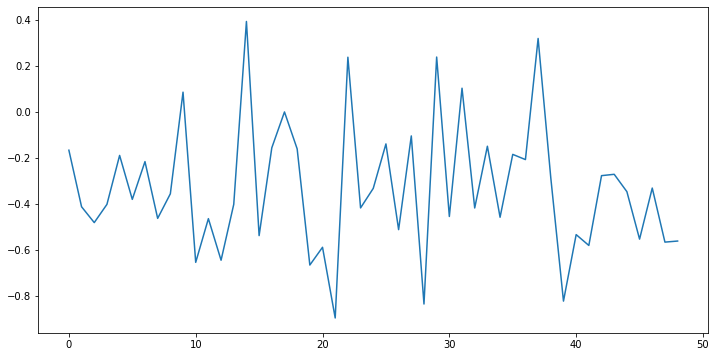

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(y[:,0,0]) #only works if yd =1

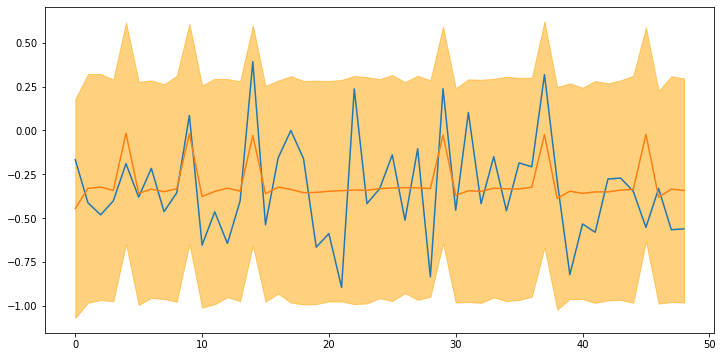

In [38]:
M=1000
x_true = np.zeros((M, T, d, 1))
y_true = np.zeros((M,T-1,yd,1))
for n in range(M):
  x_true[n,0] = x0

  #Wbar_true = npr.normal(Wbar_prior_true, Wbar_sigma_true)
  #W_true = Wbar_true[:,:d]
  #B_true = Wbar_true[:,d:]
  W_true = W_obs
  B_true = B_obs
  C_true = C_obs
  by_true = by_obs

  for t in range(1, T):
    x_true[n,t] = np.tanh(W_true @ x_true[n,t-1] + B_true @ u[t]) + sigma_true * npr.randn(d,1)
    
  ymu = C_true @ x_true[n,1:]+by_true
  y_true[n] = ymu+sigma_ytrue*npr.randn(*ymu.shape)


xtrue_mean = np.mean(x_true, axis=0)[:,0,0]
xtrue_std = np.std(x_true, axis=0)[:, 0,0]


ytrue_mean = np.mean(y_true, axis=0)[:,0,0]
ytrue_std = np.std(y_true, axis=0)[:, 0,0]


plt.figure(figsize=(12, 6))
plt.plot(y[:,0,0], label='observed y')
plt.plot(ytrue_mean, label='model')
plt.fill_between(np.arange(T-1), 
                  ytrue_mean - 2 * ytrue_std, 
                  ytrue_mean + 2 * ytrue_std,
                  color='orange',
                  alpha=0.5)

In [0]:
spwl_tanh = StochPiecewiseLinearTanh(num_parts=numparts, window=window,  temp=temp)
state = State(y[:T_train-1], x[:T_train], W, B, u[:T_train], C, by)



#Burn-in period
for i in range(burn_iters):
  spwl_tanh.gibbs_step(state,sigma, sigma_y, Wbar_prior, Wbar_sigma,Wbary_prior, Wbary_sigma, train_weights)
  print(i)

#Collect samples
x_samples = np.zeros((num_iters-burn_iters,T_train,d,1))
Wbar_samples = np.zeros((num_iters-burn_iters,Wbar_prior.shape[0], Wbar_prior.shape[1]))
Wbary_samples = np.zeros((num_iters-burn_iters,Wbary_prior.shape[0], Wbary_prior.shape[1]))
#z_samples =  np.zeros((num_iters-burn_iters,T-1))
for i in range(num_iters-burn_iters):
  spwl_tanh.gibbs_step(state,sigma, sigma_y, Wbar_prior, Wbar_sigma, Wbary_prior, Wbary_sigma, train_weights)
  x_samples[i] = state.x
  Wbar_samples[i] = state.get_Wbar()
  Wbary_samples[i] = state.get_Wybar()
  #z_samples[i] = state.z
  print(i)


Streaming output truncated to the last 5000 lines.
78453
78454
78455
78456
78457
78458
78459
78460
78461
78462
78463
78464
78465
78466
78467
78468
78469
78470
78471
78472
78473
78474
78475
78476
78477
78478
78479
78480
78481
78482
78483
78484
78485
78486
78487
78488
78489
78490
78491
78492
78493
78494
78495
78496
78497
78498
78499
78500
78501
78502
78503
78504
78505
78506
78507
78508
78509
78510
78511
78512
78513
78514
78515
78516
78517
78518
78519
78520
78521
78522
78523
78524
78525
78526
78527
78528
78529
78530
78531
78532
78533
78534
78535
78536
78537
78538
78539
78540
78541
78542
78543
78544
78545
78546
78547
78548
78549
78550
78551
78552
78553
78554
78555
78556
78557
78558
78559
78560
78561
78562
78563
78564
78565
78566
78567
78568
78569
78570
78571
78572
78573
78574
78575
78576
78577
78578
78579
78580
78581
78582
78583
78584
78585
78586
78587
78588
78589
78590
78591
78592
78593
78594
78595
78596
78597
78598
78599
78600
78601
78602
78603
78604
78605
78606
78607
78608
78609
78610
7

In [0]:
#Generate training data
xpreds = np.zeros((num_iters-burn_iters, T, d, 1))
ypreds = np.zeros((num_iters-burn_iters, T-1, yd, 1))
ypreds2 = np.zeros((num_iters-burn_iters, T_train-1, yd, 1))


xpreds_test = np.zeros((num_iters-burn_iters, T, d, 1))
ypreds_test = np.zeros((num_iters-burn_iters, T-T_train, yd, 1))

'''
EWbar = np.mean(Wbar_samples, axis=0)
W = EWbar[:,:N]
B = EWbar[:,N:]
'''

for n in range(num_iters-burn_iters):
  xpreds[n,0] = x0

  Wbar = Wbar_samples[n] 
  W = Wbar[:,:d]
  B = Wbar[:,d:]

  Wbary = Wbary_samples[n] 
  C = Wbary[:,:d]
  by = Wbary[:,d:]
  
  for t in range(1,T):
    #Using Sampled Weights
    mu_pred,_ = spwl_tanh.f(W @ xpreds[n, t-1] + B @ u[t],return_z=True)
    xpreds[n, t] = mu_pred + sigma * npr.randn(*mu_pred.shape)

  muy = C @ xpreds[n,1:]+by
  ypreds[n] = muy+sigma_y*npr.randn(*muy.shape)
  muy = C @ x_samples[n, 1:]+ by
  ypreds2[n] = muy + sigma_y*npr.randn(*muy.shape)

  xpreds_test[n, T_train-1]=x_samples[n,-1] 
  #xpreds_test[n, T_train-1]=xpreds[n,T_train-1]
  #ut = u[T_train]
  for t in range(T_train,T):
    mu_pred,_ = spwl_tanh.f(W @ xpreds_test[n, t-1] + B @ u[t],return_z=True)
    #mu_pred,_ = spwl_tanh.f(W @ xpreds_test[n, t-1] + B @ ut,return_z=True)
    xpreds_test[n, t] = mu_pred + sigma * npr.randn(*mu_pred.shape)
    #muy = C @ xpreds_test[n, t]+by
    #ypreds_test[n,t-T_train] = muy+sigma_y*npr.randn(*muy.shape)
    #ut = np.concatenate((ypreds_test[n,t-T_train], np.ones(ypreds_test[n,t-T_train].shape)))
  muy = C @ xpreds_test[n, T_train:]+by
  ypreds_test[n] = muy+sigma_y*npr.randn(*muy.shape)


xpreds_mean = np.mean(xpreds, axis=0)[:,0,0]
xpreds_std = np.std(xpreds, axis=0)[:, 0,0]


xpostpreds_mean = np.mean(xpreds_test[:,T_train:], axis=0)[:,0,0]
xpostpreds_std = np.std(xpreds_test[:,T_train:], axis=0)[:, 0,0]


ypreds_mean = np.mean(ypreds, axis=0)[:,0,0]
ypreds_std = np.std(ypreds, axis=0)[:, 0,0]

ypreds2_mean = np.mean(ypreds2, axis=0)[:,0,0]
ypreds2_std = np.std(ypreds2, axis=0)[:, 0,0]

ypreds_test_mean = np.mean(ypreds_test, axis=0)[:,0,0]
ypreds_test_std = np.std(ypreds_test, axis=0)[:, 0,0]



Plot Results

In [0]:
#Inference results
xsample_mean = np.mean(x_samples, axis=0)[:,0,0]
xsample_std = np.std(x_samples,axis=0)[:,0,0]
plot_inf(y,x, T,T_train,  xsample_mean, xsample_std, sigma, d, numparts, temp)

In [0]:
#Prediction results
print(xpostpreds_mean.shape)
plotx_pred(T,T_train,xpreds_mean, xpreds_std, xtrue_mean, xtrue_std, xpostpreds_mean, xpostpreds_std, sigma, d, numparts, temp)

In [0]:
plot_y_preds(y,T-1,T_train, ypreds_mean, ypreds_std, ytrue_mean, ytrue_std,ypreds_test_mean, ypreds_test_std,Wbar_prior, Wbar_sigma, sigma, num_iters, numparts, temp)
#plt.plot(ypreds2_mean)
#plt.fill_between(np.arange(T_train-1), 
#                  ypreds2_mean - 2 * ypreds2_std, 
#                  ypreds2_mean + 2 * ypreds2_std,
#                  color='purple',
#                  alpha=0.3)

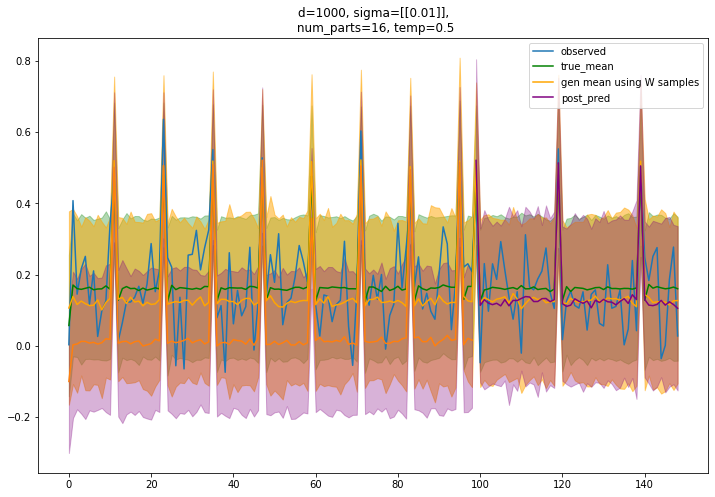

In [80]:
plot_y_obs(y, T-1,T_train, ypreds_mean, ypreds_std, ytrue_mean, ytrue_std,ypreds_test_mean, ypreds_test_std,Wbar_prior, Wbar_sigma, sigma, num_iters, numparts, temp)
plt.plot(ypreds2_mean)
plt.fill_between(np.arange(T_train-1), 
                  ypreds2_mean - 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,
                  color='purple',
                  alpha=0.3)

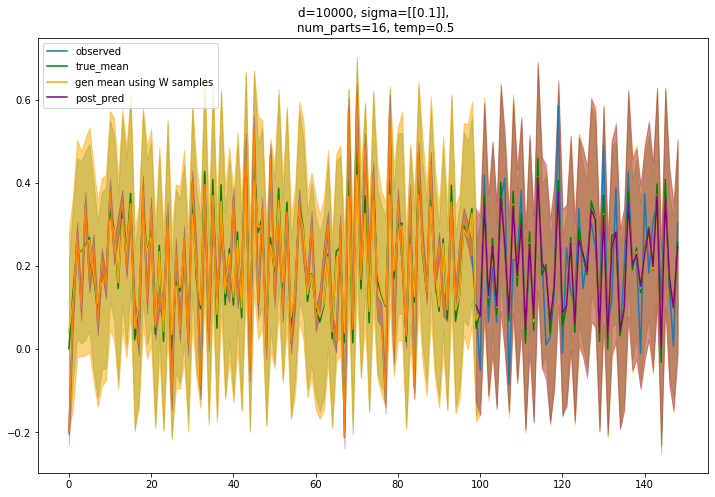

In [66]:
plot_y_obs(y, T-1,T_train, ypreds_mean, ypreds_std, ytrue_mean, ytrue_std,ypreds_test_mean, ypreds_test_std,Wbar_prior, Wbar_sigma, sigma, num_iters, numparts, temp)
plt.plot(ypreds2_mean)
plt.fill_between(np.arange(T_train-1), 
                  ypreds2_mean - 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,
                  color='purple',
                  alpha=0.3)

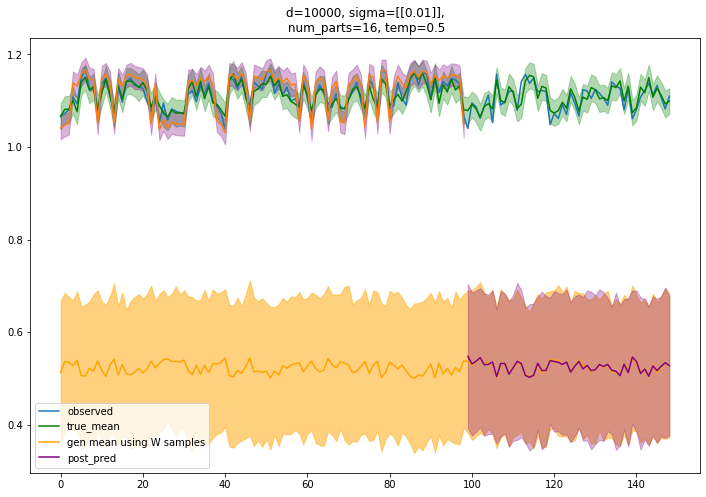

In [54]:
plot_y_obs(y, T-1,T_train, ypreds_mean, ypreds_std, ytrue_mean, ytrue_std,ypreds_test_mean, ypreds_test_std,Wbar_prior, Wbar_sigma, sigma, num_iters, numparts, temp)
plt.plot(ypreds2_mean)
plt.fill_between(np.arange(T_train-1), 
                  ypreds2_mean - 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,
                  color='purple',
                  alpha=0.3)

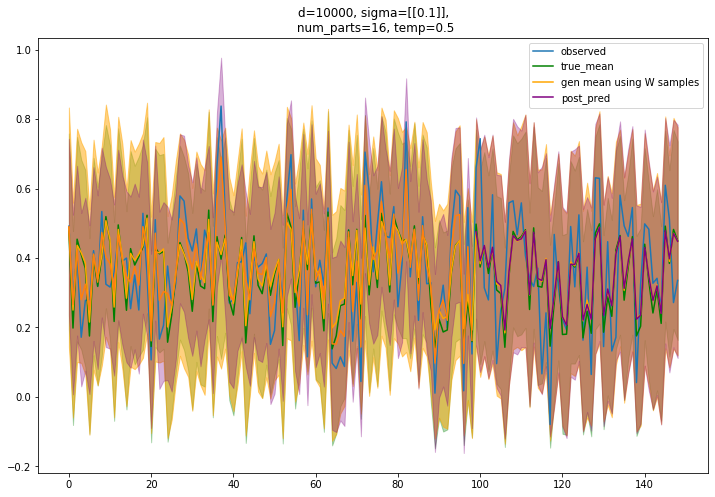

In [48]:
plot_y_obs(y, T-1,T_train, ypreds_mean, ypreds_std, ytrue_mean, ytrue_std,ypreds_test_mean, ypreds_test_std,Wbar_prior, Wbar_sigma, sigma, num_iters, numparts, temp)
plt.plot(ypreds2_mean)
plt.fill_between(np.arange(T_train-1), 
                  ypreds2_mean - 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,
                  color='purple',
                  alpha=0.3)

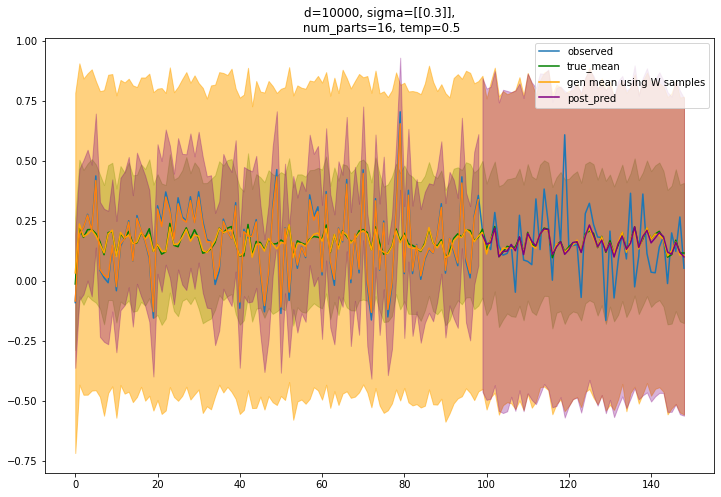

In [42]:
plot_y_obs(y, T-1,T_train, ypreds_mean, ypreds_std, ytrue_mean, ytrue_std,ypreds_test_mean, ypreds_test_std,Wbar_prior, Wbar_sigma, sigma, num_iters, numparts, temp)
plt.plot(ypreds2_mean)
plt.fill_between(np.arange(T_train-1), 
                  ypreds2_mean - 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,
                  color='purple',
                  alpha=0.3)

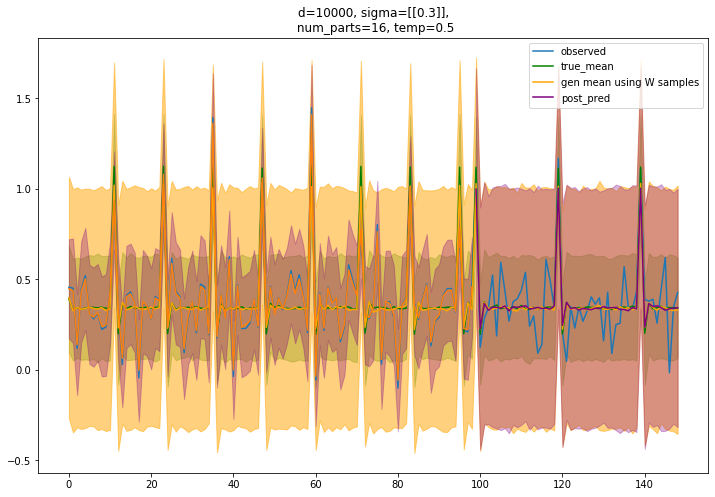

In [33]:
plot_y_obs(y, T-1,T_train, ypreds_mean, ypreds_std, ytrue_mean, ytrue_std,ypreds_test_mean, ypreds_test_std,Wbar_prior, Wbar_sigma, sigma, num_iters, numparts, temp)
plt.plot(ypreds2_mean)
plt.fill_between(np.arange(T_train-1), 
                  ypreds2_mean - 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,
                  color='purple',
                  alpha=0.3)

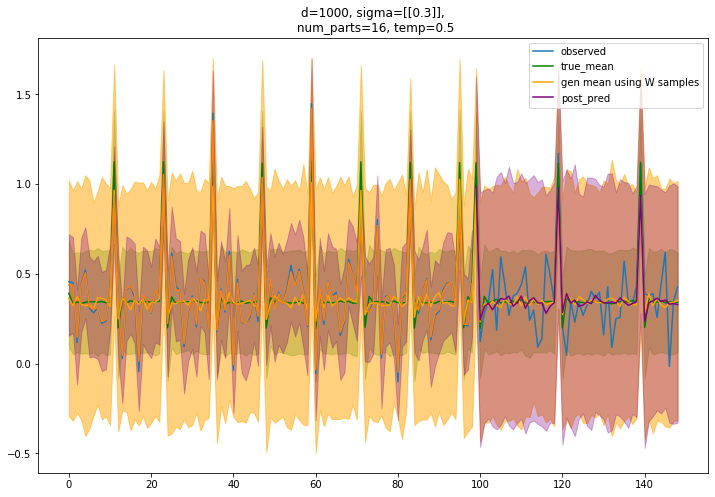

In [27]:
plot_y_obs(y, T-1,T_train, ypreds_mean, ypreds_std, ytrue_mean, ytrue_std,ypreds_test_mean, ypreds_test_std,Wbar_prior, Wbar_sigma, sigma, num_iters, numparts, temp)
plt.plot(ypreds2_mean)
plt.fill_between(np.arange(T_train-1), 
                  ypreds2_mean - 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,
                  color='purple',
                  alpha=0.3)

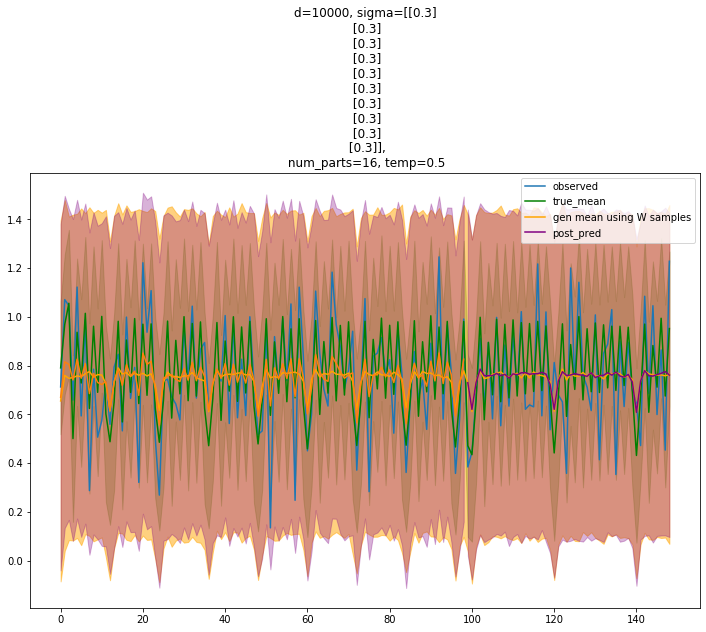

In [40]:
plot_y_obs(y, T-1,T_train, ypreds_mean, ypreds_std, ytrue_mean, ytrue_std,ypreds_test_mean, ypreds_test_std,Wbar_prior, Wbar_sigma, sigma, num_iters, numparts, temp)
plt.plot(ypreds2_mean)
plt.fill_between(np.arange(T_train-1), 
                  ypreds2_mean - 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,
                  color='purple',
                  alpha=0.3)

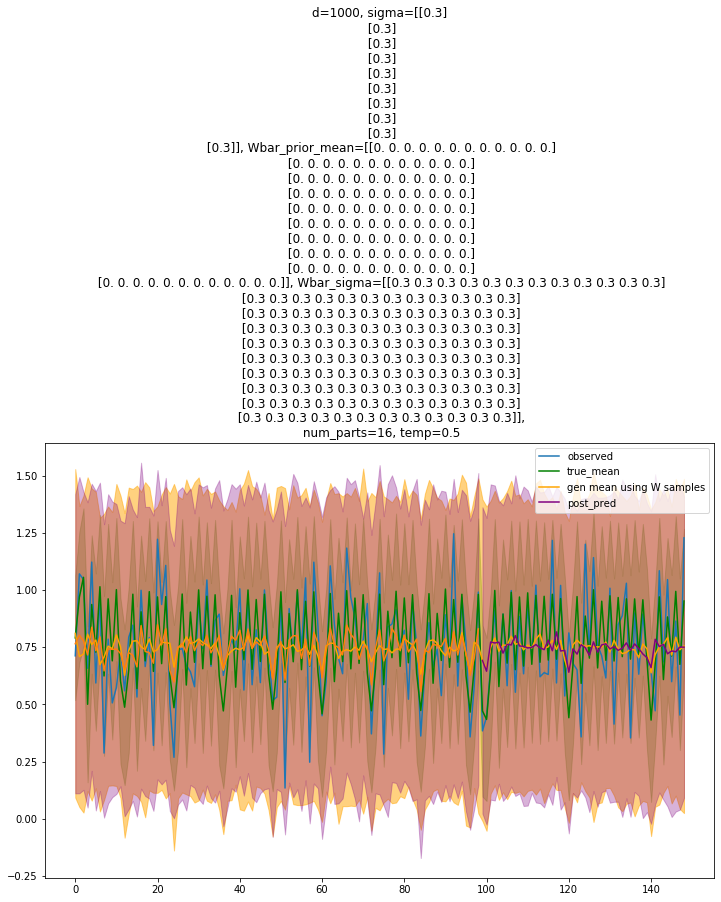

In [33]:
plot_y_obs(y, T-1,T_train, ypreds_mean, ypreds_std, ytrue_mean, ytrue_std,ypreds_test_mean, ypreds_test_std,Wbar_prior, Wbar_sigma, sigma, num_iters, numparts, temp)
plt.plot(ypreds2_mean)
plt.fill_between(np.arange(T_train-1), 
                  ypreds2_mean - 2 * ypreds2_std, 
                  ypreds2_mean + 2 * ypreds2_std,
                  color='purple',
                  alpha=0.3)